In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

✅ Model loaded successfully.
✅ Automatically selected image: /kaggle/input/osteoporosis-dataset/Combined Dataset/Combined Dataset/osteoprosis/Osteoporosis 4.png


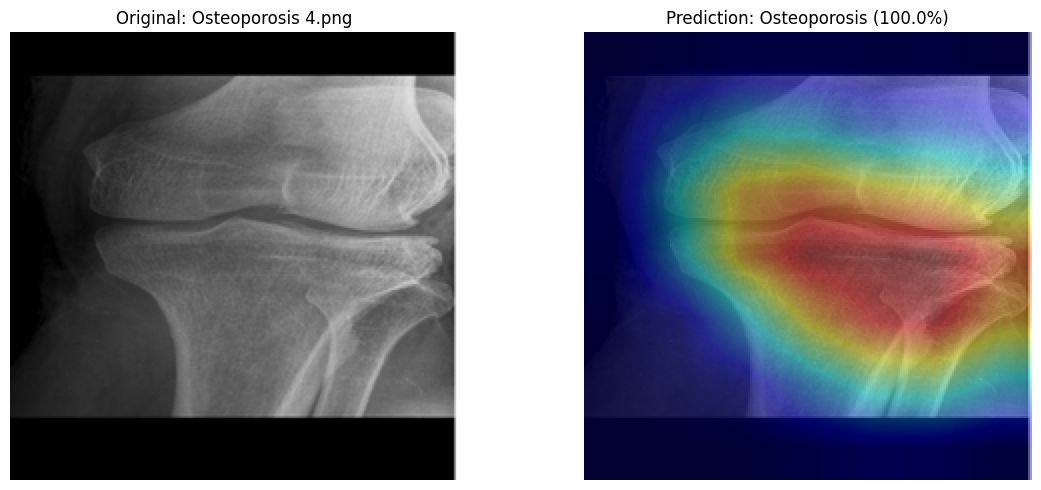

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# ==========================================
# 1. SETUP & MODEL DEFINITION
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class names (These are for display labels only)
# Note: Even though folders are lowercase, we display them neatly here.
CLASS_NAMES = ['Normal', 'Osteopenia', 'Osteoporosis'] 

def build_model(num_classes):
    """Rebuilds the exact architecture used in training"""
    model = models.resnet50(weights=None) 
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# ==========================================
# 2. GRAD-CAM CLASS
# ==========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # Forward
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        
        # Backward
        self.model.zero_grad()
        target = output[0][class_idx]
        target.backward()

        # Generate Heatmap
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activation = self.activations[0]
        for i in range(activation.shape[0]):
            activation[i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activation, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0) # ReLU
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap) # Normalize
            
        return heatmap, class_idx, output

# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================
def preprocess_image(img_path):
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])
    raw_image = Image.open(img_path).convert('RGB')
    raw_image = raw_image.resize((224, 224))
    input_tensor = transform(raw_image).unsqueeze(0)
    return raw_image, input_tensor

def show_cam_on_image(img, mask):
    img = np.array(img) / 255.0
    heatmap = cv2.resize(mask, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255.0
    heatmap = heatmap[..., ::-1] # BGR to RGB
    cam = heatmap * 0.4 + img * 0.6
    return np.uint8(255 * cam / np.max(cam))

def find_an_image(base_path):
    """
    Automatically finds a valid image in your specific directory structure.
    Looks for the 'osteoprosis' folder first (based on your screenshot).
    """
    # 1. Look for the folder name exactly as shown in your image (lowercase, missing 'o')
    target_folder = os.path.join(base_path, 'osteoprosis')
    
    # Fallback: if that doesn't exist, try standard spelling or other classes
    if not os.path.exists(target_folder):
        print(f"Note: '{target_folder}' not found. Searching other folders...")
        for sub in ['Osteoporosis', 'osteoporosis', 'normal', 'osteopenia']:
            temp_path = os.path.join(base_path, sub)
            if os.path.exists(temp_path):
                target_folder = temp_path
                break
    
    # 2. Grab the first image file inside
    if os.path.exists(target_folder):
        files = [f for f in os.listdir(target_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        if len(files) > 0:
            full_path = os.path.join(target_folder, files[0])
            print(f"✅ Automatically selected image: {full_path}")
            return full_path
            
    print("❌ Could not find any images in the dataset folders.")
    return None

# ==========================================
# 4. MAIN EXECUTION
# ==========================================

# --- A. Load Model ---
model_path = '/kaggle/input/osteoporosis-detector/pytorch/default/1/best_osteoporosis_model.pth' 
model = build_model(len(CLASS_NAMES))

if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    print("✅ Model loaded successfully.")
else:
    print(f"❌ Model file '{model_path}' not found. Make sure it is in the Output directory.")

model.to(device)
model.eval()

# --- B. Initialize Grad-CAM ---
grad_cam = GradCAM(model, model.layer4)

# --- C. Run on an Image from your Directory ---
# Your specific path from the screenshot:
dataset_root = "/kaggle/input/osteoporosis-dataset/Combined Dataset/Combined Dataset"

test_image_path = find_an_image(dataset_root)

if test_image_path:
    # 1. Preprocess
    orig_image, input_tensor = preprocess_image(test_image_path)
    input_tensor = input_tensor.to(device)

    # 2. Run Grad-CAM
    heatmap, predicted_idx, scores = grad_cam(input_tensor)

    # 3. Visualize
    visualization = show_cam_on_image(orig_image, heatmap)
    probs = F.softmax(scores, dim=1).cpu().detach().numpy()[0]
    
    # 4. Plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(orig_image)
    plt.title(f"Original: {os.path.basename(test_image_path)}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    pred_label = CLASS_NAMES[predicted_idx]
    plt.title(f"Prediction: {pred_label} ({probs[predicted_idx]*100:.1f}%)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

📂 Loading image from local path...


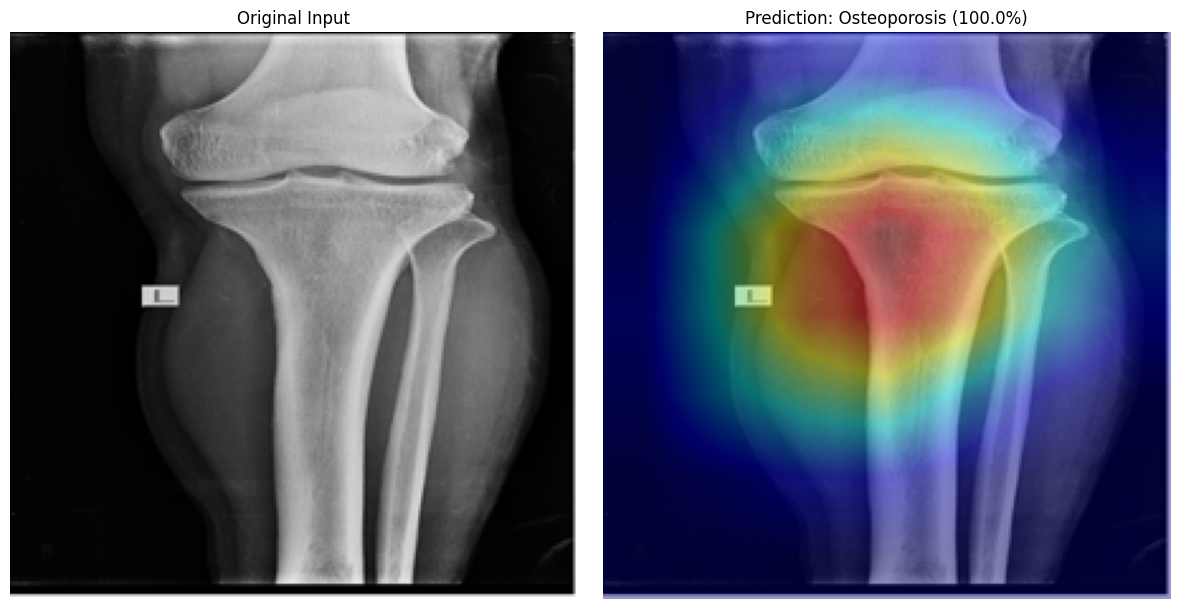


🔍 Detailed Scores:
   Normal: 0.00%
   Osteopenia: 0.00%
   Osteoporosis: 100.00%


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests
from io import BytesIO
import os

# ==========================================
# 1. SETUP & MODEL DEFINITION
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASS_NAMES = ['Normal', 'Osteopenia', 'Osteoporosis'] 

def build_model(num_classes):
    model = models.resnet50(weights=None) 
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# ==========================================
# 2. GRAD-CAM CLASS
# ==========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        
        self.model.zero_grad()
        target = output[0][class_idx]
        target.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activation = self.activations[0]
        for i in range(activation.shape[0]):
            activation[i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activation, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)
            
        return heatmap, class_idx, output

# ==========================================
# 3. SMART IMAGE LOADER
# ==========================================
def load_image_from_source(source):
    """Loads image from a URL or a local file path."""
    try:
        if source.startswith(('http://', 'https://')):
            print(f"🌐 Downloading image from URL...")
            response = requests.get(source)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            print(f"📂 Loading image from local path...")
            if not os.path.exists(source):
                raise FileNotFoundError(f"File not found: {source}")
            img = Image.open(source).convert('RGB')
        return img
    except Exception as e:
        print(f"❌ Error loading image: {e}")
        return None

def preprocess_image(pil_image):
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])
    
    # Resize for display
    display_image = pil_image.resize((224, 224))
    # Transform for model
    input_tensor = transform(pil_image).unsqueeze(0)
    
    return display_image, input_tensor

def show_cam_on_image(img, mask):
    img = np.array(img) / 255.0
    heatmap = cv2.resize(mask, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255.0
    heatmap = heatmap[..., ::-1]
    cam = heatmap * 0.4 + img * 0.6
    return np.uint8(255 * cam / np.max(cam))

# ==========================================
# 4. MAIN EXECUTION (USER INPUT)
# ==========================================

# ---------------------------------------------------------
# 👇 PASTE YOUR LINK OR FILE PATH HERE 👇
IMAGE_SOURCE = "/kaggle/input/osteoporosis-dataset/Combined Dataset/Combined Dataset/osteoprosis/144.png"
# ---------------------------------------------------------

# Load Model
model_path = '/kaggle/input/osteoporosis-detector/pytorch/default/1/best_osteoporosis_model.pth' 
model = build_model(len(CLASS_NAMES))
if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    
    grad_cam = GradCAM(model, model.layer4)

    # Process Input
    pil_image = load_image_from_source(IMAGE_SOURCE)

    if pil_image:
        # Prepare
        orig_image, input_tensor = preprocess_image(pil_image)
        input_tensor = input_tensor.to(device)

        # Run Inference
        heatmap, predicted_idx, scores = grad_cam(input_tensor)

        # Visualize
        visualization = show_cam_on_image(orig_image, heatmap)
        probs = F.softmax(scores, dim=1).cpu().detach().numpy()[0]
        
        # Plot
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(orig_image)
        plt.title("Original Input")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(visualization)
        pred_label = CLASS_NAMES[predicted_idx]
        confidence = probs[predicted_idx] * 100
        plt.title(f"Prediction: {pred_label} ({confidence:.1f}%)")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n🔍 Detailed Scores:")
        for i, name in enumerate(CLASS_NAMES):
            print(f"   {name}: {probs[i]*100:.2f}%")
else:
    print(f"❌ Model file '{model_path}' not found. Please ensure it is in your working directory.")